## Install Libraries

In [18]:
%pip install -U weaviate-client plotly numpy
%pip install --upgrade nbformat kaleido

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [19]:
import os
import requests, json
import weaviate
import numpy as np
from weaviate.classes.config import Configure, VectorDistances
import weaviate.classes as wvc

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import plotly.express as px


## Create Schema and Populate DSM Data

In [20]:
client = weaviate.connect_to_local()
try:
    dsm = client.collections.create(
        name="DSM",
        vector_config=Configure.Vectors.text2vec_transformers(
            name="text_vector",
            source_properties=["text"],
            vector_index_config=Configure.VectorIndex.hnsw(
                # https://docs.weaviate.io/weaviate/config-refs/distances
                distance_metric=VectorDistances.COSINE
            ),
        ),
    )

    directory = "./chunks"
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename)) as f:
                jsn = json.loads(f.read())

                cks = jsn["chunks"]
                for i,c in enumerate(cks):
                    with dsm.batch.dynamic() as batch:
                        batch.add_object(
                            {
                                "key": f"{jsn['id']}::{i}",
                                "title": jsn["title"],
                                "text": c,
                            }
                        )
except Exception as ex:
    print("probably already exists", ex)
finally:
    client.close()

probably already exists Collection may not have been created properly.! Unexpected status code: 422, with response body: {'error': [{'message': 'class name DSM already exists'}]}.


## Tests Query

In [21]:
# client = weaviate.connect_to_weaviate_cloud(
#     cluster_url=weaviate_url,                                    # Replace with your Weaviate Cloud URL
#     # auth_credentials=wvc.init.Auth.api_key(weaviate_api_key),    # Replace with your Weaviate Cloud key
#     # headers={"X-OpenAI-Api-Key": openai_api_key}            # Replace with appropriate header key/value pair for the required API
# )
import pprint

client = weaviate.connect_to_local()
try:
    collection = client.collections.use("DSM")

    # results = collection.query.hybrid(
    #     # https://deepwiki.com/weaviate/weaviate-python-client/5.2-keyword-and-hybrid-search
    #     return_metadata=wvc.query.MetadataQuery(
    #         score=True,
    #         explain_score=True,
    #         distance=True,
    #         certainty=True
    #     ),
    #     query="patient has been complaining of lack of sleep and low mood",
    #     alpha=0.5,  # Equal balance between BM25 and vector search
    #     target_vector="text_vector",
    #     limit=4,
    # )
    # pprint.pprint(results)

    # response = collection.query.bm25()
    # https://deepwiki.com/weaviate/weaviate/6.2-keyword-search-(bm25)
    # https://medium.com/etoai/hybrid-search-combining-bm25-and-semantic-search-for-better-results-with-lan-1358038fe7e6

    results = collection.query.near_text(
       # Because near_text is a purely vector search, you get a distance instead of a score.
        return_metadata=wvc.query.MetadataQuery(
            score=True, explain_score=True, distance=True, certainty=True
        ),
        query="patient complains of inablity to stay asleep, low mood, and doesn't care about day to day activities",
        limit=4
    )
    for r in results.objects:
        print(f"distance: {r.metadata.distance}, certainty: {r.metadata.certainty}, score: {round((1-r.metadata.distance)*100, 1)}%")
        print(r.properties['title'])
        print(r.properties['text'][:180].replace("\n",""))
        print("----------------------------")

finally:
    client.close()  # Close client gracefully

# Most text embeddings (e.g., from BERT, Sentence-BERT, etc.) are normalized, so cosine similarity is between 0 and 1.

distance: 0.14292281866073608, certainty: 0.9285385608673096, score: 85.7%
Anxiety Disorders
persistent and excessive fear or reluctance about being alone or without major attachment figures at home or in other settings. Children with separation anxiety disorder may be una
----------------------------
distance: 0.1457483172416687, certainty: 0.9271258115768433, score: 85.4%
Sleep-Wake Disorders
###### **Associated Features**  Insomnia is often associated with physiological and cognitive arousal and conditioning factors that interfere with sleep. A preoccupation with sleep
----------------------------
distance: 0.145846426486969, certainty: 0.9270768165588379, score: 85.4%
Bipolar and Related Disorders
Inflated self-esteem is typically present, ranging from uncritical selfconfidence to marked grandiosity, and may reach delusional proportions (Criterion B1). Despite lack of any pa
----------------------------
distance: 0.14879298210144043, certainty: 0.9256035089492798, score: 85.1%
Depr

## Fetch All Vectors

In [22]:
client = weaviate.connect_to_local()
try:
    dsm = client.collections.get("DSM")
    response = dsm.query.fetch_objects(limit=10000, include_vector=True)

    vectors = np.array([np.array(obj.vector["text_vector"]) for obj in response.objects])
    titles = np.array(np.array([obj.properties["title"] for obj in response.objects]))

    print(f"Fetched {len(vectors)} vectors.")
except Exception as ex:
    print(f"Error: {ex}")
finally:
    client.close()

Fetched 1957 vectors.


## PCA and Graph DSM Data

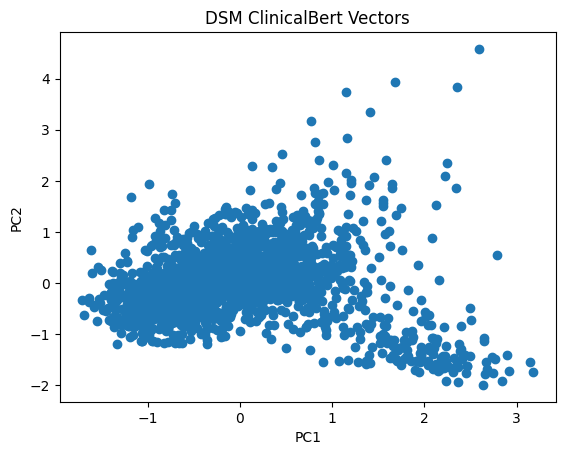

In [23]:
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(vectors)

unique_titles = list(set(titles))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_titles)))

plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
plt.title("DSM ClinicalBert Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [24]:
fig = px.scatter_3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    color=titles,
    title="DSM ClinicalBert Vectors",
    size_max=3,
    opacity=0.7
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    width=1200,   # in pixels
    height=800,   # in pixels
    title_font_size=20,
)
fig.show()

fig.write_html("graphs/pca_plot_version1.html")
fig.write_image(
    "graphs/pca_plot_version1.png",
    width=1200,
    height=800,
    scale=1
)


/Users/robrohan/miniconda3/envs/spikes/lib/python3.11/site-packages/plotly/io/_kaleido.py:510: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.


